# Auto ownership estimation

In [1]:
import os; os.chdir('..')
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import warnings;
import glob
warnings.simplefilter('ignore')

import pyproj as proj
from shapely.geometry import MultiPoint
from shapely import geometry

from collections import OrderedDict
from urbansim_templates import modelmanager as mm
from urbansim_templates.models import SmallMultinomialLogitStep
import orca
import seaborn as sns
%matplotlib notebook

from scripts import datasources, models, variables



In [2]:
mm.initialize()

Loading model step 'WLCM'


In [3]:
orca.run(['initialize_network_small', 'network_aggregations_small'])

Running step 'initialize_network_small'
Time to execute step 'initialize_network_small': 0.00 s
Running step 'network_aggregations_small'
Computing accessibility variables
Computing units_10000
Computing units_sf_10000
Computing units_mf_10000
Computing pop_10000
Removed 189769 rows because they contain missing values
Computing hh_10000
Removed 189769 rows because they contain missing values
Computing poor_10000
Removed 53114 rows because they contain missing values
Computing renters_10000
Removed 102597 rows because they contain missing values
Computing avg_income_10000
Removed 189769 rows because they contain missing values
Computing jobs_10000
Computing avg_rent_10000
Computing pop_white_10000
Removed 107372 rows because they contain missing values
Computing pop_black_10000
Removed 10541 rows because they contain missing values
Computing pop_asian_10000
Removed 51048 rows because they contain missing values
Computing pop_hisp_10000
Removed 31685 rows because they contain missing val

In [ ]:
# orca.run(['initialize_network_walk','network_aggregations_walk']);

Running step 'initialize_network_walk'
Time to execute step 'initialize_network_walk': 0.00 s
Running step 'network_aggregations_walk'
Computing accessibility variables
Computing units_500_walk
Computing sqft_unit_500_walk
Computing singles_500_walk
Removed 52084 rows because they contain missing values
Computing elderly_hh_500_walk
Removed 34553 rows because they contain missing values
Computing children_500_walk
Removed 189769 rows because they contain missing values
Computing units_sf_500_walk
Computing units_mf_500_walk
Computing pop_500_walk
Removed 189769 rows because they contain missing values
Computing hh_500_walk
Removed 189769 rows because they contain missing values
Computing poor_500_walk
Removed 53114 rows because they contain missing values
Computing rich_500_walk
Removed 38964 rows because they contain missing values
Computing renters_500_walk
Removed 102597 rows because they contain missing values
Computing avg_income_500_walk
Removed 189769 rows because they contain m

In [4]:
cars_alt = orca.get_table('households').to_frame()['cars'].apply(lambda x: 0*(x==0)+ 1*(x==1)+2*(x==2)+3*(x>=3))
orca.add_column('households', 'cars_alt', cars_alt)

In [5]:
# income bins
income_bins = pd.cut(orca.get_table('households').to_frame().income,
      bins = [0,20000,40000,60000,80000,100000,120000,np.inf],
      labels = ['2','4','6','8','10','12','12p'],include_lowest = True)
income_bin_dummies = pd.get_dummies(income_bins,prefix = 'income')
for i in income_bin_dummies.columns:
    orca.add_column('households',i,income_bin_dummies[i])

# tenure type dummy
orca.add_column('households','tenure_1',(orca.get_table('households').to_frame()['tenure']==1).astype(int))
orca.add_column('households','tenure_2',(orca.get_table('households').to_frame()['tenure']==2).astype(int))
orca.add_column('households','tenure_3',(orca.get_table('households').to_frame()['tenure']==3).astype(int))
orca.add_column('households','tenure_4',(orca.get_table('households').to_frame()['tenure']==4).astype(int))

# single family as integer
orca.add_column('households','single_family_int',(orca.get_table('households').to_frame()['single_family'].astype(int)))

# building type dummy
orca.add_column('households','building_type_2',(orca.get_table('households').to_frame()['building_type']==2).astype(int))

In [6]:
parcels = orca.get_table('parcels').to_frame()

In [7]:
# bart station within 1/4 mile:
from sklearn.neighbors import BallTree

bart = pd.read_csv('./gtfs/stops.txt')[['stop_id','stop_lat','stop_lon']].set_index('stop_id')
bart_rad = np.deg2rad(bart[['stop_lat','stop_lon']])
parcels_rad = np.deg2rad(parcels[['y','x']])
tree = BallTree(bart_rad,metric = 'haversine')
dist, ind = tree.query(parcels_rad,k=1)
parcel_has_bart = (dist*6371<=0.5).astype(int)
orca.add_column('parcels','has_bart',parcel_has_bart)

In [8]:
county_dummies = pd.get_dummies(parcels['county_id'].astype(int),prefix='county')
for i in county_dummies.columns:
    orca.add_column('parcels',i,county_dummies[i])


In [9]:
@orca.table(cache=True)
def hh_merged():
    df = orca.merge_tables(target = 'households',tables = ['households','units','buildings','parcels','nodessmall'])
    return df

In [10]:
m2 = SmallMultinomialLogitStep()
m2.name = 'auto_ownership'

In [11]:
m2.tables = ['hh_merged']
m2.choice_column = 'cars_alt'

In [17]:
m2.model_expression = OrderedDict([
    ('intercept', [1,2,3]), 
    ('income_2',[0]),
    ('income_4',[0]),
    ('income_6',[1]),
    ('income_8',[1]),
    ('income_10',[1,2,3]),
    ('income_12',[1,2,3]),
    ('income_12p',[1,2,3]),
    ('persons',[1,2,3]),
    ('age_of_head',[1,2,3]),
    ('workers',[2,3]),
    ('children',[1,3]),
    ('single_family_int',[1,2,3]),
    ('tenure_1',[[1,2,3]]),
    ('has_bart',[[1,2,3]]),
    ('county_1',[[1,2,3]]),
    ('county_75', [[1,2,3]]),
    ('units_sf_10000',[1,2,3]),
     ('renters_10000',[1,2,3]),
    
     ])


In [13]:
chooser_ids = orca.get_table('households').to_frame().sample(15000,random_state = 3).index.values # sample 15000 based on household ID
m2.filters = ['household_id in [{0}]'.format(','.join(map(str, chooser_ids)))]

In [18]:
m2.fit()

Log-likelihood at zero: -19,406.7348
Initial Log-likelihood: -19,406.7348
Estimation Time for Point Estimation: 1.59 seconds.
Final log-likelihood: -13,060.9650
                     Multinomial Logit Model Regression Results                    
Dep. Variable:                     _chosen   No. Observations:               13,999
Model:             Multinomial Logit Model   Df Residuals:                   13,960
Method:                                MLE   Df Model:                           39
Date:                     Fri, 28 Sep 2018   Pseudo R-squ.:                   0.327
Time:                             20:31:57   Pseudo R-bar-squ.:               0.325
AIC:                            26,199.930   Log-Likelihood:            -13,060.965
BIC:                            26,494.253   LL-Null:                   -19,406.735
                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------

In [19]:
m2.tags = ['auto','auto ownership','jayne','test']
m2.register()

Model saved to configs/auto_ownership.pkl
Saving 'auto_ownership.yaml': /home/jayne/ual_model_workspace/fall-2018-models/configs
Loading model step 'auto_ownership'


In [20]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
clf0 = RandomForestClassifier(n_estimators=100, max_depth=2,
                              random_state=0)
df = orca.get_table('hh_merged').to_frame().sample(15000,random_state = 2)



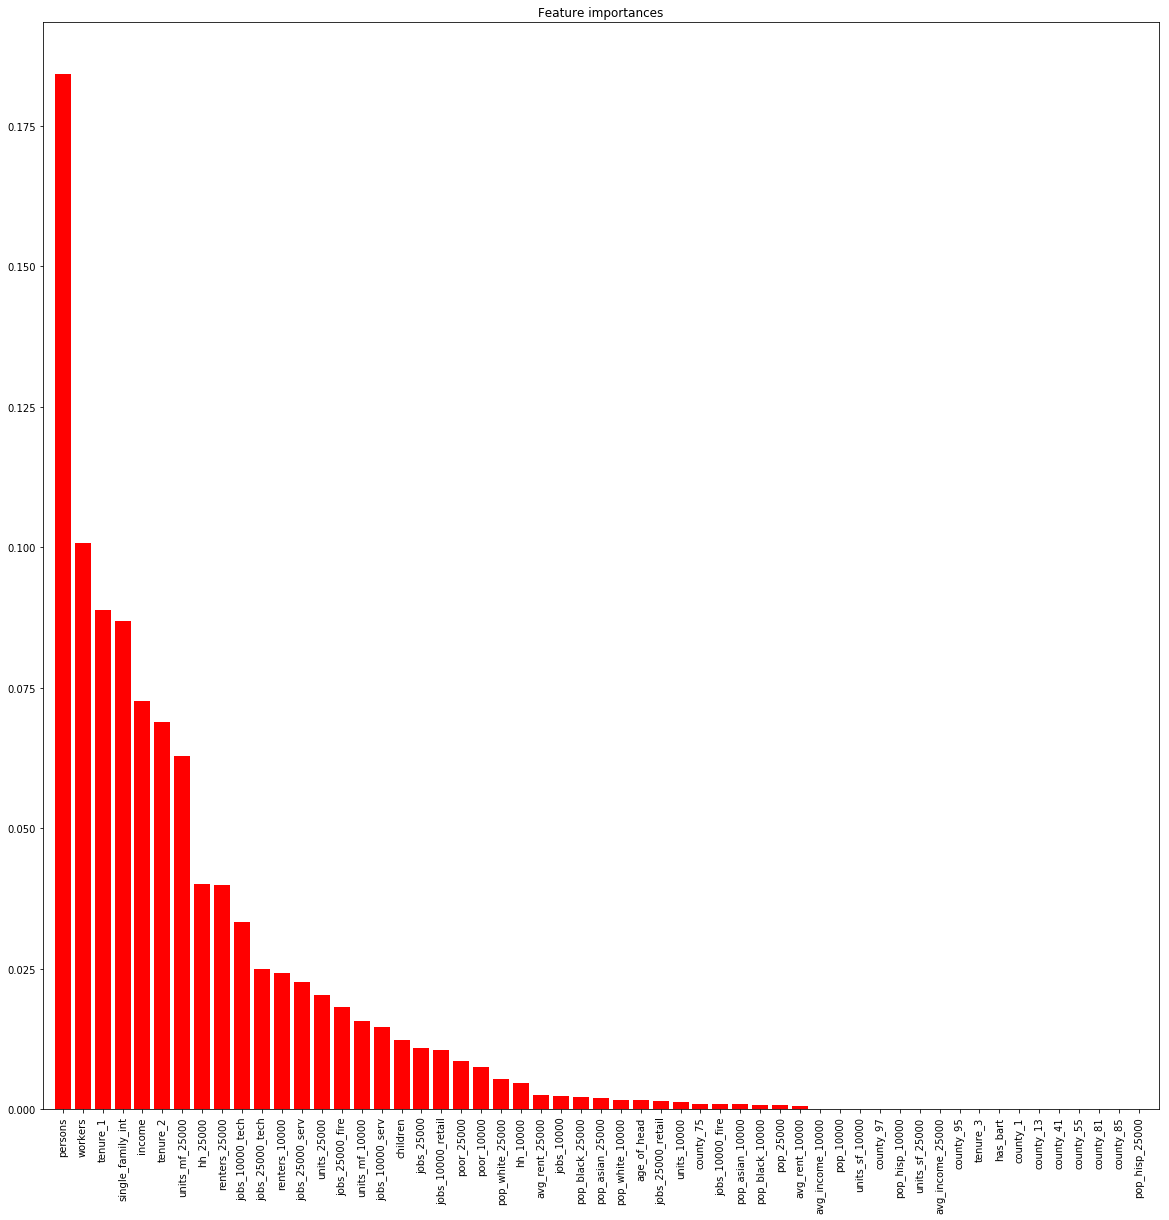

In [21]:
acc_cols = list(orca.get_table('nodessmall').to_frame().columns)
X0 = df[acc_cols + ['income','persons','age_of_head','workers','children',
         'single_family_int','tenure_1','tenure_2','tenure_3','has_bart','county_1', 'county_13', 'county_41',
       'county_55', 'county_75', 'county_81', 'county_85', 'county_95',
       'county_97'
         
        ]]
y = df['cars_alt']

clf0.fit(X0,y)
importances = clf0.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize = (20,20))
plt.title("Feature importances")
plt.bar(range(X0.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(X0.shape[1]), X0.columns[indices],rotation = 90)
plt.xlim([-1, X0.shape[1]])
plt.show()

In [22]:
X1 = X0[X0.columns[importances>0.01]]
cross_val_score(clf0, X1, y, cv=4)

array([0.55211943, 0.5483871 , 0.54467858, 0.55028007])

In [23]:
# feature used in X1
X1.columns

Index(['units_mf_10000', 'renters_10000', 'units_25000', 'units_mf_25000',
       'hh_25000', 'renters_25000', 'jobs_25000', 'jobs_10000_retail',
       'jobs_25000_fire', 'jobs_10000_tech', 'jobs_25000_tech',
       'jobs_10000_serv', 'jobs_25000_serv', 'income', 'persons', 'workers',
       'children', 'single_family_int', 'tenure_1', 'tenure_2'],
      dtype='object')